<a href="https://colab.research.google.com/github/ImanariRoll/kaggleRGOL/blob/master/rgol_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd gdrive/My\ Drive/rgol

Mounted at /content/gdrive
/content/gdrive/My Drive/rgol


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 



import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Conv2DTranspose, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt


In [4]:


# my generators
moore = [(-1, -1), (-1, 0), (-1, 1),\
            (0, -1), (0, 1),\
            (1, -1), (1, 0), (1, 1)]

def evolve(X, K, S, B):
    """Return the next cellular automaton state."""
    adjacent = np.zeros(X.shape)
    for i, j in K:
        adjacent += np.roll(X, [i, j], [0, 1])
        
    next_state = np.where(X, np.isin(adjacent, S), np.isin(adjacent, B))
    return next_state + 0

def golgen(state):
    """Conway's Game of Life cellular automaton generator."""
    while True:
        state = evolve(state, moore, [2, 3], [3])
        yield state
        
# my make_move function
def make_move(state, moves):
    gen = golgen(state)
    for _ in range(moves):
        state = next(gen)
        
    return state


In [118]:
# original author's generators
NROW, NCOL = 25, 25

def generate_samples(delta=1, n=32):
    """
    Generate batch of samples
    
    @return: (end_frames, start_frames)
    """
    # uint8 is an 8-bit unsigned integer
    # split into n batches of NROWxNCOL grids
    batch = np.split(np.random.binomial(1, 0.5, (NROW * n, NCOL)).astype('uint8'), n)
    Yy = [life.make_move(state, 5) for state in batch] # transition each state in batch
    # is this because we want to learn actual gol states, not just random starting states?
    Xx = [life.make_move(state, 1) for state in Yy] # transition each state in batch 
    Y = np.array([y.ravel() for y in Yy])
    X = np.array([x.ravel() for x in Xx])
    return X, Y
    
# this is the same function writen as a generator
def data_generator(delta=1, batch_size=32, ravel=True):
    """
    Can be used along with .fit_generator to generate training samples on the fly
    """
    while True:
        batch = np.split(np.random.binomial(1, 0.5, (NROW * batch_size, NCOL)).astype('uint8'), batch_size)
        Yy = [make_move(state, 5) for state in batch]
        Xx = [make_move(state, 5 + delta) for state in Yy]

        if ravel:
            # turn grids into 1D
            Y = np.array([y.ravel() for y in Yy])
            X = np.array([x.ravel() for x in Xx])
            yield X, Y
        else:
            yield np.array(Xx)[:,:, :, np.newaxis], np.array(Yy)[:, :, :, np.newaxis]
            
def create_model(n_hidden_convs=2, n_hidden_filters=128, kernel_size=5):
    nn = Sequential()
    # hidden filters, kernel size, padding, activation?
    nn.add(Conv2D(n_hidden_filters, kernel_size, padding='same', activation='relu', input_shape=(25, 25, 1)))
    # what is batch normalization?
    nn.add(BatchNormalization())
    for i in range(n_hidden_convs):
        nn.add(Conv2D(n_hidden_filters, kernel_size, padding='same', activation='relu'))
        nn.add(BatchNormalization())
    nn.add(Conv2D(1, kernel_size, padding='same', activation='sigmoid'))
    nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return nn

def model_v2():
    # This one performs worse then pure Conv2D
    nn = Sequential()
    nn.add(Conv2D(128, 5, padding='same', activation=lrelu, input_shape=(25, 25, 1)))
    nn.add(BatchNormalization())
    nn.add(Conv2D(128, 5, padding='valid', activation=lrelu))
    nn.add(BatchNormalization())
    nn.add(MaxPool2D())
    nn.add(Conv2DTranspose(128, 2, strides=(2, 2), padding='valid', activation=lrelu))
    nn.add(BatchNormalization())
    nn.add(Conv2DTranspose(128, 5, strides=(1, 1), padding='valid', activation=lrelu))
    nn.add(BatchNormalization())
    nn.add(Conv2D(1, 5, padding='same', activation='sigmoid'))
    nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return nn


In [ ]:
# TRAIN THE MODELS
models = []
for delta in range(1, 6):
    model = create_model(n_hidden_convs=6, n_hidden_filters=256)
    es = EarlyStopping(monitor='loss', patience=9, min_delta=0.001)
    model.fit(data_generator(delta=delta, ravel=False), steps_per_epoch=500, epochs=50, verbose=1, callbacks=[es])
    models.append(model)
    
   

Epoch 1/50
500/500 [==============================] - 52s 104ms/step - loss: 0.5488 - accuracy: 0.7581
Epoch 2/50
500/500 [==============================] - 52s 104ms/step - loss: 0.5260 - accuracy: 0.7675
Epoch 3/50
500/500 [==============================] - 51s 101ms/step - loss: 0.5259 - accuracy: 0.7673
Epoch 4/50
500/500 [==============================] - 50s 100ms/step - loss: 0.5259 - accuracy: 0.7671
Epoch 5/50
500/500 [==============================] - 50s 99ms/step - loss: 0.5241 - accuracy: 0.7679
Epoch 6/50
500/500 [==============================] - 49s 99ms/step - loss: 0.5257 - accuracy: 0.7671
Epoch 7/50
500/500 [==============================] - 50s 99ms/step - loss: 0.5227 - accuracy: 0.7683
Epoch 8/50
500/500 [==============================] - 50s 99ms/step - loss: 0.5231 - accuracy: 0.7678
Epoch 9/50
500/500 [==============================] - 49s 99ms/step - loss: 0.5225 - accuracy: 0.7681
Epoch 10/50
500/500 [==============================] - 50s 100ms/step - loss: 

In [10]:
# GOD SAVE THE MODELS!!!
save_models()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model0/assets
INFO:tensorflow:Assets written to: model1/assets
INFO:tensorflow:Assets written to: model2/assets
INFO:tensorflow:Assets written to: model3/assets
INFO:tensorflow:Assets written to: model4/assets


In [5]:
import keras

In [11]:
train_df = pd.read_csv('data/train.csv', index_col=0)
test_df = pd.read_csv('data/test.csv', index_col=0)


In [ ]:
# old
submit_df = pd.DataFrame(index=test_df.index, columns=['start.' + str(_) for _ in range(1, 401)])

for delta in range(1, 6):
    mod = models[delta-1]
    delta_df = test_df[test_df.delta == delta].iloc[:, 1:].values.reshape(-1, 25, 25, 1)
    submit_df[test_df.delta == delta] = mod.predict(delta_df).reshape(-1, 400).round(0).astype('uint8')
    
submit_df.to_csv('submission.csv')

In [ ]:
# test model with images

In [49]:
delta_df = train_df[train_df.delta == 5].iloc[:, 1:626].values.reshape(-1, 25, 25, 1)

In [50]:
results = models[4].predict(delta_df)

In [ ]:
results[0]

In [51]:
import matplotlib.pyplot as plt

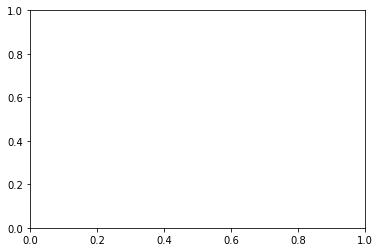

In [52]:
fig, ax = plt.subplots()

In [ ]:
baz = np.zeros((10113, 25, 25))

for x in range(len(results)):
  for i in range(len(results[0])):
    for j in range(len(results[0][0])):
      baz[x][i][j] = results[x][i][j][0]

In [53]:
baz = results.reshape(-1, 25, 25)

In [ ]:
baz

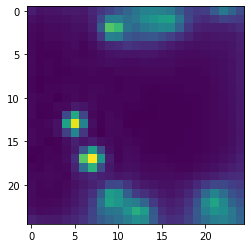

In [57]:
plt.imshow(baz[1])

In [55]:
seeds = train_df[train_df.delta == 5].iloc[:, 626:].values.reshape(-1, 25, 25)

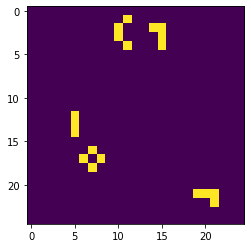

In [58]:
plt.imshow(seeds[1])

In [62]:
final = train_df[train_df.delta == 5].iloc[:, 1:626].values.reshape(-1, 25, 25)

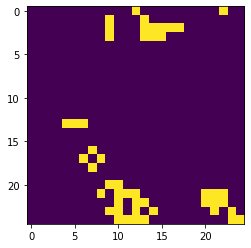

In [73]:
plt.imshow(final[1])

In [80]:
gen = golgen(final[1])

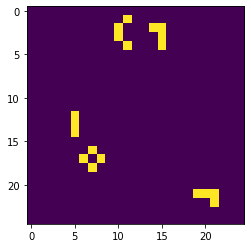

In [85]:
plt.imshow(next(gen))

In [78]:
# set up system for working with saved models
#   function that loads models and outputs a list of them

# save models
def save_models():
  for i in range(5):
    models[i].save(f'model{i}')

# load models
def load_models():
  models = []
  for i in range(5):
    models.append(keras.models.load_model(f'model{i}'))
  return models 
# test predictions for each delta, compare to test data
#   for each model in models
#   get first prediction for each model
def get_prediction(delta):
  # must have shape (-1, 25, 25, 1) for keras predict. (-1, 25, 25) for imshow

  delta_df = train_df[train_df.delta == delta].iloc[:, 1:626].values.reshape(-1, 25, 25, 1)
  input = delta_df.reshape(-1, 25, 25)
  predicted = models[delta-1].predict(delta_df).reshape(-1, 25, 25)
  actual = train_df[train_df.delta == delta].iloc[:, 626:].values.reshape(-1, 25, 25)
  return input, actual, predicted
# make submission dataset
# figure out how to submit

# how to TPU?


In [ ]:
 datasets = get_prediction(5)

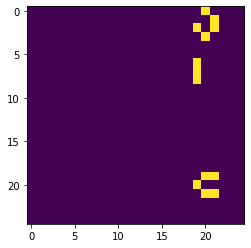

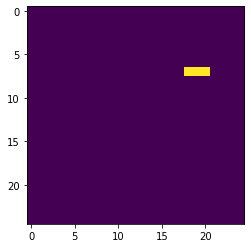

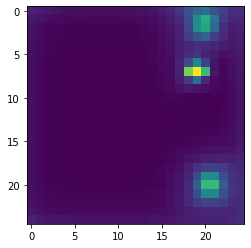

In [ ]:
n = 2
for ds in datasets:
  fig, ax = plt.subplots()
  ax.imshow(ds[n])

In [18]:
# use test set to evaluate
n = 5
x_test = train_df[train_df.delta == n].iloc[:, 1:626].values.reshape(-1, 25, 25, 1)
y_test = train_df[train_df.delta == n].iloc[:, 626:].values.reshape(-1, 25, 25, 1)

In [19]:
models[n-1].evaluate(x_test, y_test, batch_size=128)

78/78 [==============================] - 10s 126ms/step - loss: 8.2336 - accuracy: 0.8262


[8.233599662780762, 0.8262033462524414]

In [ ]:
1251 /2

625.5

In [11]:
models = load_models()

In [20]:
# submission data set
submit_df = pd.DataFrame(index=test_df.index, columns=['start_' + str(_) for _ in range(0, 625)])

for delta in range(1, 6):
    mod = models[delta-1]
    delta_df = test_df[test_df.delta == delta].iloc[:, 1:].values.reshape(-1, 25, 25, 1)
    submit_df[test_df.delta == delta] = mod.predict(delta_df).reshape(-1, 625).round(0).astype('uint8')
    
submit_df.to_csv('submission.csv')

In [27]:
625*50000*2

62500000

In [21]:
submit_df = pd.read_csv('submission.csv')

In [22]:
submit_df

,id,start_0,start_1,start_2,start_3,start_4,start_5,start_6,start_7,start_8,start_9,start_10,start_11,start_12,start_13,start_14,start_15,start_16,start_17,start_18,start_19,start_20,start_21,start_22,start_23,start_24,start_25,start_26,start_27,start_28,start_29,start_30,start_31,start_32,start_33,start_34,start_35,start_36,start_37,start_38,...,start_585,start_586,start_587,start_588,start_589,start_590,start_591,start_592,start_593,start_594,start_595,start_596,start_597,start_598,start_599,start_600,start_601,start_602,start_603,start_604,start_605,start_606,start_607,start_608,start_609,start_610,start_611,start_612,start_613,start_614,start_615,start_616,start_617,start_618,start_619,start_620,start_621,start_622,start_623,start_624
0,50000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,50001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,50002,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,1,1,0,1,1,0,0,0,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0
3,50003,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,50004,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,99995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49996,99996,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49997,99997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49998,99998,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [29]:
submit_df

,id,start_0,start_1,start_2,start_3,start_4,start_5,start_6,start_7,start_8,start_9,start_10,start_11,start_12,start_13,start_14,start_15,start_16,start_17,start_18,start_19,start_20,start_21,start_22,start_23,start_24,start_25,start_26,start_27,start_28,start_29,start_30,start_31,start_32,start_33,start_34,start_35,start_36,start_37,start_38,...,start_585,start_586,start_587,start_588,start_589,start_590,start_591,start_592,start_593,start_594,start_595,start_596,start_597,start_598,start_599,start_600,start_601,start_602,start_603,start_604,start_605,start_606,start_607,start_608,start_609,start_610,start_611,start_612,start_613,start_614,start_615,start_616,start_617,start_618,start_619,start_620,start_621,start_622,start_623,start_624
0,50000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,50001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,50002,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,1,1,1,1,1,0,0,0,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0
3,50003,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,50004,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,99995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49996,99996,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49997,99997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49998,99998,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
pwd

'/content/gdrive/My Drive/rgol'

In [ ]:
# how to submit?
# get models from github
# use models to produce output in kaggle kernel

In [108]:
# test dataset
n = 5
start = train_df[train_df.delta == n].iloc[:, 1:626].values.reshape(-1, 25, 25)[0]
stop = train_df[train_df.delta == n].iloc[:, 626:].values.reshape(-1, 25, 25)[0]

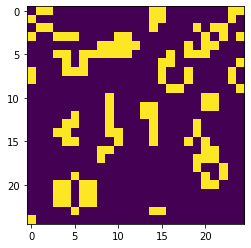

In [109]:
plt.imshow(start)

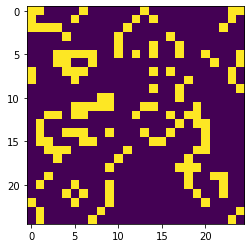

In [114]:
gen = golgen(start)
plt.imshow([next(gen) for _ in range(5)][4])

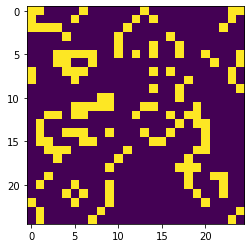

In [115]:
plt.imshow(stop)

In [116]:
test_df

,delta,stop_0,stop_1,stop_2,stop_3,stop_4,stop_5,stop_6,stop_7,stop_8,stop_9,stop_10,stop_11,stop_12,stop_13,stop_14,stop_15,stop_16,stop_17,stop_18,stop_19,stop_20,stop_21,stop_22,stop_23,stop_24,stop_25,stop_26,stop_27,stop_28,stop_29,stop_30,stop_31,stop_32,stop_33,stop_34,stop_35,stop_36,stop_37,stop_38,...,stop_585,stop_586,stop_587,stop_588,stop_589,stop_590,stop_591,stop_592,stop_593,stop_594,stop_595,stop_596,stop_597,stop_598,stop_599,stop_600,stop_601,stop_602,stop_603,stop_604,stop_605,stop_606,stop_607,stop_608,stop_609,stop_610,stop_611,stop_612,stop_613,stop_614,stop_615,stop_616,stop_617,stop_618,stop_619,stop_620,stop_621,stop_622,stop_623,stop_624
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50000,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
50001,5,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,0,...,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,1,0,1,0,0,0,0
50002,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,...,0,0,1,1,1,1,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0
50003,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,...,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0
50004,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
99996,2,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
99997,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
